In [ ]:
%matplotlib inline


Los fundamentos de Autograd
============================

La función *Autograd* de PyTorch es parte de lo que hace que PyTorch sea flexible y rápido para crear proyectos de aprendizaje automático. Permite el cálculo rápido y sencillo de múltiples derivadas parciales (también conocidas como *gradientes)* en un cálculo complejo. Esta operación es fundamental para el aprendizaje de redes neuronales basado en backpropagation.

El poder de autograd proviene del hecho de que rastrea su
computación dinámicamente *en tiempo de ejecución*, lo que significa que si su modelo tiene ramas de decisión o bucles cuyas longitudes no se conocen hasta el tiempo de ejecución, la computación aún se rastreará correctamente y obtendrá gradientes correctos para impulsar el aprendizaje. Esto, combinado con el hecho de que sus modelos están construidos en Python, ofrece mucha más flexibilidad que los frameworks que se basan en el análisis estático de un modelo de estructura más rígida para calcular gradientes.

¿Para qué necesitamos Autograd?
--------------------------------------------

Un modelo de aprendizaje automático es una *función*, con entradas y salidas. Para esta discusión, trataremos las entradas a como un vector de dimensión *i* $\vec{x}$, con elementos $x_{i}$. Entonces podemos expresar el modelo, *M*, como una función vectorial de la entrada: $\vec{y} = \vec{M}(\vec{x})$. (Tratamos el valor de la salida de M como un vector porque, en general, un modelo puede tener cualquier número de salidas).

Dado que principalmente hablaremos de autograd en el contexto del entrenamiento, nuestro resultado de interés será la pérdida del modelo. La *función de pérdida* L($\vec{y}$) = L($\vec{M}$\ ($\vec{x}$)) es una función escalar de valor único de la salida del modelo. Esta función expresa qué tan lejos estaba la predicción de nuestro modelo de la salida *ideal* de una entrada en particular. *Nota: después de este punto, a menudo omitiremos el signo del vector donde debería ser contextualmente claro, por ejemplo,* $y$ en lugar de $\vec y$.

Al entrenar un modelo, queremos minimizar la pérdida. En el caso idealizado de un modelo perfecto, eso significa ajustar sus pesos de aprendizaje, es decir, los parámetros ajustables de la función, de modo que la pérdida sea cero para todas las entradas. En el mundo real, significa un proceso iterativo de empujar los pesos de aprendizaje hasta que veamos que obtenemos una pérdida tolerable para una amplia variedad de entradas.

¿Cómo decidimos hasta dónde y en qué dirección empujar los pesos? Queremos *minimizar* la pérdida, lo que significa hacer que su primera derivada con respecto a la entrada sea igual a 0:
$\frac{\partial L}{\partial x} = 0$.

Sin embargo, recuerde que la pérdida no se deriva *directamente* de la entrada, sino que es una función de la salida del modelo (que es una función directa de la entrada), $\frac{\partial L}{\partial x}$ =
$\frac{\partial {L({\vec y})}}{\partial x}$. 

Por la regla de la cadena del cálculo diferencial, tenemos
$\frac{\partial {L({\vec y})}}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial y}{\partial x}$ =
$\frac{\partial L}{\partial y}\frac{\partial M(x)}{\partial x}$.

$\frac{\partial M(x)}{\partial x}$ es donde las cosas se ponen complejas.
Las derivadas parciales de las salidas del modelo con respecto a su
Las entradas, si tuviéramos que expandir la expresión usando la regla de la cadena nuevamente, involucrarían muchas derivadas parciales locales sobre cada peso de aprendizaje multiplicado, cada función de activación y cualquier otra transformación matemática en el modelo. La expresión completa para cada derivada parcial es la suma de los productos del gradiente local de *todas las rutas posibles* a través del gráfico de cálculo que termina con la variable cuyo gradiente estamos tratando de medir.

En particular, los gradientes sobre los pesos de aprendizaje nos interesan: nos dicen *en qué dirección cambiar cada peso* para acercar la función de pérdida a cero.

Dado que el número de tales derivados locales (cada uno correspondiente a una ruta separada a través del gráfico de cálculo del modelo) tenderá a aumentar exponencialmente con la profundidad de una red neuronal, también lo hace la complejidad de calcularlos. Aquí es donde entra en juego autograd: realiza un seguimiento del historial de cada cálculo. Cada tensor calculado en su modelo PyTorch lleva un historial de sus tensores de entrada y la función utilizada para crearlo. Combinado con el hecho de que las funciones de PyTorch destinadas a actuar sobre tensores tienen una implementación integrada para calcular sus propias derivadas, esto acelera enormemente el cálculo de las derivadas locales necesarias para el aprendizaje.






Un ejemplo sencillo
----------------

Eso fue mucha teoría, pero ¿cómo se ve usar autograd en
¿práctica?

Comencemos con un ejemplo sencillo. Primero, haremos algunas importaciones.
para graficar nuestros resultados:

In [1]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

A continuación, crearemos un tensor de entrada lleno de valores espaciados uniformemente en el intervalo $[0, 2{\pi}]$ y especificaremos ``requires_grad=True``. (Como la mayoría de las funciones que crean tensores, ``torch.linspace()`` acepta una opción ``requires_grad`` opcional). Establecer este indicador significa que en cada cálculo que sigue, autograd acumulará el historial del cálculo en el tensores de salida de ese cálculo.


In [2]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)



A continuación, realizaremos un cálculo y graficaremos su salida en términos de sus entradas:



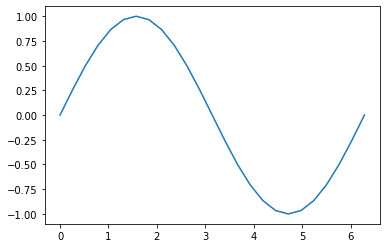

In [3]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())


Echemos un vistazo más de cerca al tensor ``b``. Cuando lo imprimimos, vemos un indicador de que está rastreando su historial de cómputo:



In [4]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


Este ``grad_fn`` nos da una pista de que cuando ejecutemos el
paso de backpropagation y calculemos los gradientes, necesitaremos calcular la derivada de $sin(x)$ para todas las entradas de este tensor.

Realicemos algunos cálculos más:




In [5]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finalmente, calculemos una salida de un solo elemento. Cuando llamas a ``.backward()`` en un tensor sin argumentos, se espera que el tensor de llamada contenga solo un elemento, como es el caso cuando se calcula una función de pérdida.




In [6]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Cada ``grad_fn`` almacenado con nuestros tensores le permite recorrer el cálculo hasta sus entradas con su atributo ``next_functions``. Podemos ver a continuación que profundizar en este atributo en ``d`` nos muestra las funciones de gradiente para todos los tensores anteriores. Tenga en cuenta que ``a.grad_fn`` se informa como ``None``, lo que indica que esta fue una entrada a la función sin historial propio.




In [7]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f786df1bb10>, 0), (None, 0))
((<SinBackward0 object at 0x7f786df1bf10>, 0), (None, 0))
((<AccumulateGrad object at 0x7f786df1bb10>, 0),)
()

c:

b:

a:
None


Con toda esta maquinaria en su lugar, ¿cómo sacamos las derivadas? Llama al método ``backward()`` en la salida y verifica el atributo ``grad`` de la entrada para inspeccionar los gradientes:




tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


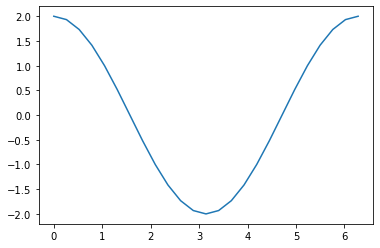

In [8]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())

Recuerde los pasos de cálculo que tomamos para llegar aquí:

In [ ]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

Sumar una constante, como hicimos para calcular ``d``, no cambia la derivada. Eso deja $c = 2 * b = 2 * sin(a)$, cuya derivada debería ser $2 * cos(a)$. Mirando el gráfico de arriba, eso es justo lo que vemos.

Tenga en cuenta que solo los *nodos hoja* del cálculo tienen sus gradientes calculados. Si intentara, por ejemplo, ``print(c.grad)`` obtendría ``None``. En este ejemplo simple, solo la entrada es un nodo de hoja, por lo que solo ella tiene gradientes calculados.








Activar y desactivar Autograd
---------------------------

Hay situaciones en las que necesitará un control detallado sobre
si autograd está habilitado. Hay varias formas de hacer esto, dependiendo de la situación.

El más simple es cambiar el indicador ``requires_grad`` en un tensor
directamente:




In [10]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])



En la celda de arriba, vemos que ``b1`` tiene un ``grad_fn`` (es decir, un historial de cálculo rastreado), que es lo que esperamos, ya que se derivó de un tensor, ``a``, que tenía activado el autograduado. Cuando desactivamos autograd explícitamente con ``a.requires_grad = False``, ya no se rastrea el historial de cálculo, como vemos cuando calculamos ``b2``.

Si solo necesita que Autograd se apague temporalmente, una mejor manera es usar ``torch.no_grad()``:



In [11]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


``torch.no_grad()`` también se puede usar como decorador de funciones o métodos:




In [12]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


Hay un administrador de contexto correspondiente, ``torch.enable_grad()``, para activar la graduación automática cuando aún no lo está. También se puede utilizar como decorador.

Finalmente, puede tener un tensor que requiera seguimiento de gradiente, pero desea una copia que no lo requiera. Para esto tenemos el método ``detach()`` del objeto ``Tensor`` - crea una copia del tensor que se *separa* del historial de cálculo:




In [13]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.3698, 0.2335, 0.3265, 0.6040, 0.4674], requires_grad=True)
tensor([0.3698, 0.2335, 0.3265, 0.6040, 0.4674])


Hicimos esto arriba cuando queríamos graficar algunos de nuestros tensores. Esto se debe a que ``matplotlib`` espera una matriz NumPy como entrada, y la conversión implícita de un tensor PyTorch a una matriz NumPy no está habilitada para tensores con require_grad=True. Hacer una copia separada nos permite avanzar.


## Autograd y las Operaciones in situ


En todos los ejemplos de este cuaderno hasta ahora, hemos usado variables para capturar los valores intermedios de un cálculo. Autograd necesita estos valores intermedios para realizar cálculos de gradiente. ***Por esta razón, debe tener cuidado al usar operaciones in situ cuando use autograd.*** Si lo hace, puede destruir la información que necesita para calcular las derivadas en la llamada ``backward()``. PyTorch incluso lo detendrá si intenta una operación in situ en la variable de hoja que requiere autograduación, como se muestra a continuación.



In [14]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
torch.sin_(a)

RuntimeError: ignored